In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import sys
path = '/Work/EPE/ML4pi/'
sys.path.append(path)
import util.ml_util as mu
from util.ml_util import cell_meta

In [2]:
path_prefix = '/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
data_path = path_prefix + "v7/"

In [3]:
import sys
sys.path.append(path_prefix)

In [4]:
stmc_x = np.load(data_path + "X_img_pfn.npz")
stmc_y = np.load(data_path + "Y_img_pfn.npz")

In [21]:
xraw = stmc_x.f.arr_0
yraw = stmc_y.f.arr_0

In [22]:
X = xraw[:300000,:,:4]
Y = yraw[:300000]
print(X.shape)
print(Y.shape)

(300000, 636, 4)
(300000,)


In [23]:
target_zero_mask = Y > .05
Ylog = np.log(Y[target_zero_mask])
print('Any targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Y)))

Any targets below 50 GeV: 104
Number of events: 300000


In [24]:
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/.7

In [10]:
import energyflow as ef
from energyflow.archs import PFN

In [11]:
def tvt_num(_data, _tvt=(75, 10, 15)):
    ''' Function designed to output appropriate numbers for traning validation and testing given
    a variable length input. TVT expressed as ratios and do not need to add to 100. '''
    _tot = len(_data)
    _train, _val, _test = _tvt
    _tvt_sum = _train + _val + _test
    
    _train_rtrn = round(_train*_tot/_tvt_sum)
    _val_rtrn = round(_val*_tot/_tvt_sum)
    _test_rtrn = _tot - _train_rtrn - _val_rtrn
    
    return _train_rtrn, _val_rtrn, _test_rtrn

def normalize_input1d(arr, mask):
    ''' Note that non masked values are left alone i.e. zeros if mask = arr != 0'''
    len_arr = arr.shape[0]
    mean = np.repeat(np.mean(arr, where=mask), len_arr)
    std_dev = np.repeat(np.std(arr, where=mask), len_arr)
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev!=0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

def normalize_input2d(arr, mask):
    ''' Truth value is where to perform the operation, exclude False vals.
    returns: Array with the shape of arr with normalization carried out with mask '''
    len_ax1 = arr.shape[1]
    mean = np.tile(np.mean(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    std_dev = np.tile(np.std(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev != 0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

<Figure size 799.992x599.976 with 0 Axes>

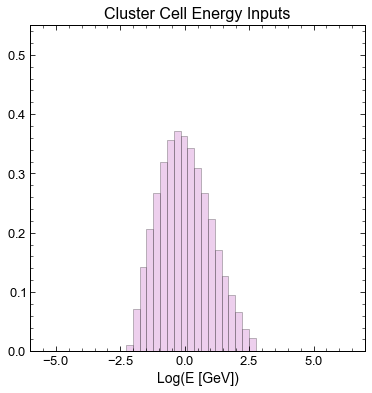

<Figure size 799.992x599.976 with 0 Axes>

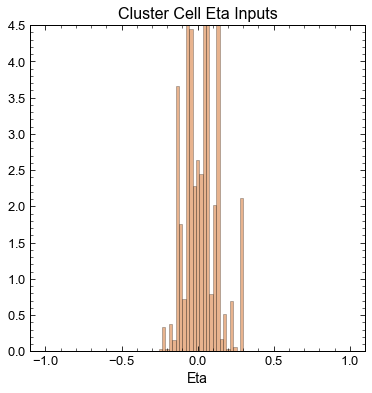

<Figure size 799.992x599.976 with 0 Axes>

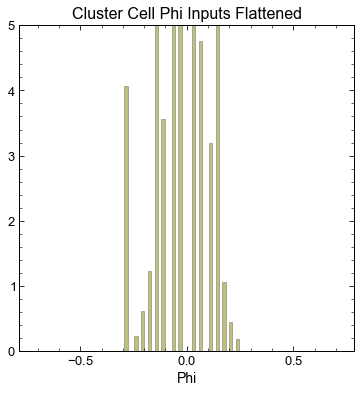

<Figure size 799.992x599.976 with 0 Axes>

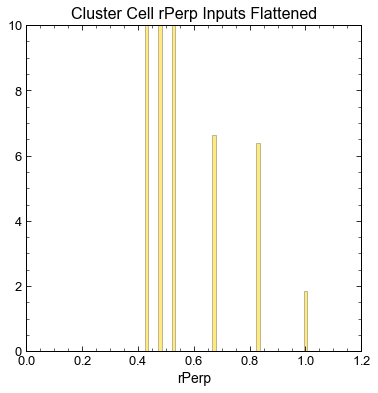

In [25]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_Einputs_2020-07-01.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1, 100, endpoint=True)
plt.hist(X[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_EtaInputs_2021-07-08.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,100, endpoint=True)
plt.hist(X[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_PhiInputs_2021-07-08.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,100, endpoint=True)
plt.hist(X[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_rPerpInputs_2021-07-08.png', format='png')
plt.show()

In [26]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = tvt_num(X[target_zero_mask], _tvt=(90, 10, 0))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 1000

MemoryError: Unable to allocate 5.68 GiB for an array with shape (299896, 636, 4) and data type float64

In [15]:
X[target_zero_mask].shape

(299896, 636, 4)

In [16]:
# dataset = tf.data.Dataset.from_tensor_slices((X, Y))
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X[target_zero_mask], Ylog, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(269906, 636, 4)
(269906,)


In [15]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from tensorflow.keras.models import load_model
import keras.backend as kb

In [16]:
kb.clear_session()
netOpt = tf.keras.optimizers.Adam(learning_rate=0.001)

pfn = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
            output_act=output_act, output_dim=output_dim, loss=loss,
            optimizer=netOpt, metrics=[])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [17]:
chkpoint = tf.keras.callbacks.ModelCheckpoint('pfn_regressor_image_3.h5', monitor='val_loss', verbose=1, save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=300, verbose=0, restore_best_weights=True)
history_ct = pfn.fit(x_train, y_train,
        epochs=num_epoch,
        batch_size=1000,
        validation_data=(x_val, y_val),
        verbose=0,
        callbacks=[chkpoint, earlystop])


Epoch 00001: val_loss improved from inf to 1.47920, saving model to pfn_regressor_image_3.h5

Epoch 00002: val_loss improved from 1.47920 to 0.64120, saving model to pfn_regressor_image_3.h5

Epoch 00003: val_loss did not improve from 0.64120

Epoch 00004: val_loss improved from 0.64120 to 0.47292, saving model to pfn_regressor_image_3.h5

Epoch 00005: val_loss did not improve from 0.47292

Epoch 00006: val_loss did not improve from 0.47292

Epoch 00007: val_loss improved from 0.47292 to 0.37348, saving model to pfn_regressor_image_3.h5

Epoch 00008: val_loss did not improve from 0.37348

Epoch 00009: val_loss did not improve from 0.37348

Epoch 00010: val_loss improved from 0.37348 to 0.32502, saving model to pfn_regressor_image_3.h5

Epoch 00011: val_loss did not improve from 0.32502

Epoch 00012: val_loss did not improve from 0.32502

Epoch 00013: val_loss did not improve from 0.32502

Epoch 00014: val_loss improved from 0.32502 to 0.31286, saving model to pfn_regressor_image_3.h5
